# Covid-19 (France)
# Predict end of pandemic by Sigmoid regression

In [52]:
import sys
sys.path.append("../lib")

In [53]:
from SigmoidRegression import SigmoidRegression

In [54]:
# If a spark session already exists
try: spark
except: spark = None

In [55]:
sr = SigmoidRegression(spark=spark, configFile="../country/fr/config.properties", dataFile="../country/fr/data.csv")

In [56]:
sr.fit()

2020-05-17 20:21:14 - Start
2020-05-17 20:21:14 - Number of parameter combinations = 12727818
2020-05-17 20:21:23 - Local data successfully created (number of rows = 12727818)
2020-05-17 20:21:23 - Disseminate data to all cores with Spark
2020-05-17 20:21:28 - Data successfully disseminated
2020-05-17 20:21:28 - Number of partitions = 32
2020-05-17 20:21:28 - Calculating the 12727818 costs and searching the minimal cost
2020-05-17 20:22:12 - Searching the row corresponding to the minimal cost
2020-05-17 20:22:13 - Amplitude = 17020.0
2020-05-17 20:22:13 - Lambda = 0.1235
2020-05-17 20:22:13 - Shift = 40.0
2020-05-17 20:22:13 - End


# Equation for prediction

In [57]:
# Round Amplitude and Shift
sr.Amplitude = round(sr.Amplitude)
sr.Shift = round(sr.Shift)

In [58]:
sr.showEquation(varName="Prediction(France)")

\begin{equation*}Prediction(France)=\frac{17020}{1+\ e^{-0.1235 (x-40)}}\end{equation*}

# Diagram

In [59]:
import datetime, time
from datetime import timedelta

def stringToDatetime(aDatetimeString, aDatetimeFormat):
    aDatetimeStruct = time.strptime(aDatetimeString, aDatetimeFormat)
    aDatetime = datetime.datetime.fromtimestamp(time.mktime(aDatetimeStruct))
    return aDatetime

def datetimeToString(aDatetime, aDatetimeFormat):
    aDatetimeString = aDatetime.strftime(aDatetimeFormat)
    return aDatetimeString

In [60]:
startDate = stringToDatetime(sr.dfIn[sr.config.get("dateColName")].to_list()[0], "%Y-%m-%d")
today = startDate + timedelta(days=len(sr.X)-1)

In [61]:
# Max X for graphic abscisse
xMax = sr.config.get("xMax")
# The last value of X
lastX = sr.X[-1]

In [62]:
# Get the Pandas dataframe containing predictions till xMax
df = sr.getDf(xMax)

In [63]:
# Search the peak date
peakDayNum = 0
peak = 0
realDiffs = df['Y_real_diff'].tolist()
for x in range(0, len(realDiffs)):
    realDiff = realDiffs[x]
    if (realDiff > peak):
        peak = realDiff
        peakDayNum = x
peakDay = startDate + timedelta(days=peakDayNum)

In [64]:
# Search the end date (when no variation between two days at the end)
dayOffNum = 0
prevY = 0
for x in range(0, xMax):
    y = round(sr.getSigmoidY(x))
    if (y == prevY):
        dayOffNum = x - 1
        break
    prevY = y
dayOff = startDate + timedelta(days=dayOffNum)

In [65]:
# Get the diagram
fig = sr.getFigure(
    xMax = xMax,
    title = "COVID-19 France - Day " + str(lastX) +
            " (" + datetimeToString(today, "%Y-%m-%d") +
            ") - Predictions by sigmoid regression",
    labelPred = "Cumulative prediction",
    labelPredDiff = "Differential prediction",
    labelData = "Cumulative real measure",
    labelDataDiff = "Differential real measure",
    height = 600,
    cartridge=False
)

## Customize the diagram

In [66]:
# Dates for (max death - n)
dayTh50 = round(sr.getSigmoidX(sr.Amplitude-50))
dateTh50 = startDate + timedelta(days=dayTh50)
dayTh100 = round(sr.getSigmoidX(sr.Amplitude-100))
dateTh100 = startDate + timedelta(days=dayTh100)

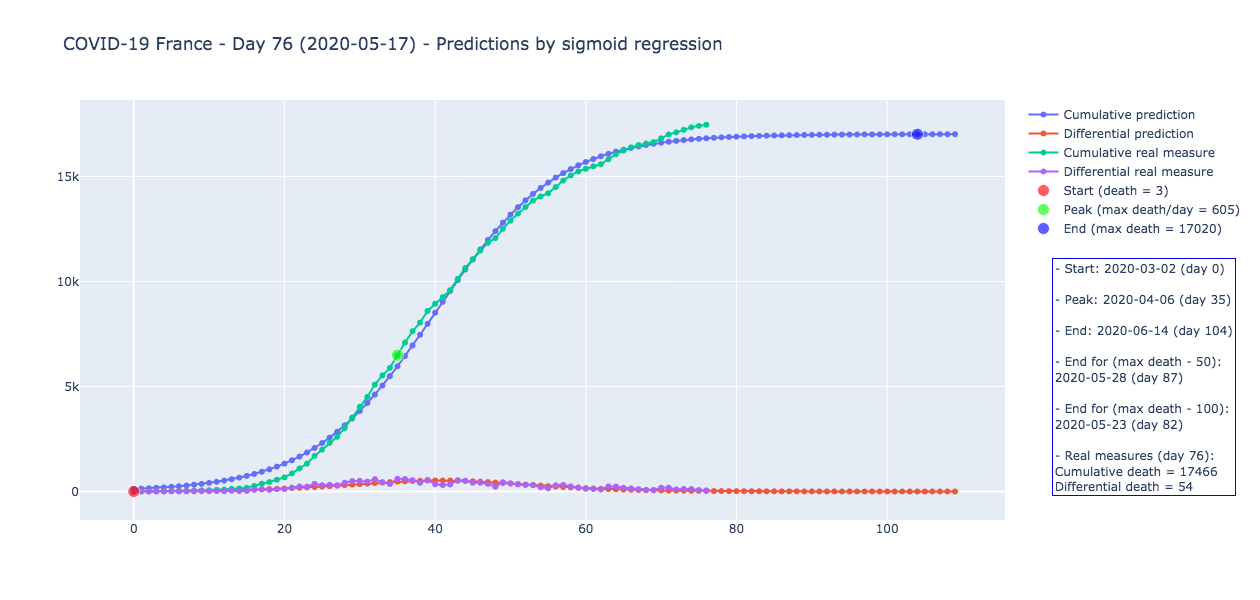

In [67]:
import plotly.graph_objects as go

# Add the red start point
fig.add_trace(go.Scatter(
    x=[0],
    y=[0],
    mode="markers",
    name = "Start (death = " + str(round(df['Y_real'].tolist()[0])) + ")",
    hovertext=["Start"],
    marker=dict(size=[12], color=['rgba(255, 0, 0, .9)'])
))

# Add the blue peak point
fig.add_trace(go.Scatter(
    x=[peakDayNum, peakDayNum],
    y=[df['Y_real'].tolist()[peakDayNum], df['Y_real_diff'].tolist()[peakDayNum]],
    mode="markers",
    name = "Peak (max death/day = " + str(round(df['Y_real_diff'].tolist()[peakDayNum])) + ")",
    hovertext=["Peak"],
    marker=dict(size=[12], color=['rgba(0, 255, 0, .9)'])
))

# Add the green end point
fig.add_trace(go.Scatter(
    x=[dayOffNum],
    y=[round(sr.getSigmoidY(dayOffNum))],
    mode="markers",
    name = "End (max death = " + str(sr.Amplitude) + ")",
    hovertext=["End"],
    marker=dict(size=[12], color=['rgba(0, 0, 255, .9)'])
))

# Add text
fig.add_annotation(go.layout.Annotation(
        text = "- Start: " + datetimeToString(startDate, "%Y-%m-%d") + " (day 0)" +
               "<br>" +
               "<br>- Peak: " + datetimeToString(peakDay, "%Y-%m-%d") + " (day " + str(peakDayNum) + ")" +
               "<br>" +
               "<br>- End: " + datetimeToString(dayOff, "%Y-%m-%d") + " (day " + str(dayOffNum) + ")" +
               "<br>" +
               "<br>- End for (max death - 50):" +
               "<br>" + datetimeToString(dateTh50, "%Y-%m-%d") + " (day " + str(dayTh50) + ")" +
               "<br>" +
               "<br>- End for (max death - 100):" +
               "<br>" + datetimeToString(dateTh100, "%Y-%m-%d") + " (day " + str(dayTh100) + ")" +
               "<br>" +
               "<br>- Real measures (day " + str(lastX) + "):" +
               "<br>Cumulative death = " + str(sr.Y[lastX]) +
               "<br>Differential death = " + str(sr.Y[lastX] - sr.Y[lastX-1]),
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=1.25,
        y=0.34,
        bordercolor='blue',
        borderwidth=1
))

# Show the diagram
fig.show()

## Show the dataframe containing the predictions

In [68]:
import pandas
n = len(df)
pandas.set_option('display.max_rows', n)
df.head(n)

X   Y_real  Y_real_diff  Y_pred  Y_pred_diff
0      0      3.0          0.0     121            0
1      1      4.0          1.0     137           16
2      2      4.0          0.0     154           17
3      3      7.0          3.0     175           21
4      4      9.0          2.0     197           22
5      5     16.0          7.0     223           26
6      6     19.0          3.0     252           29
7      7     25.0          6.0     284           32
8      8     33.0          8.0     321           37
9      9     48.0         15.0     362           41
10    10     61.0         13.0     409           47
11    11     79.0         18.0     461           52
12    12     91.0         12.0     520           59
13    13    127.0         36.0     586           66
14    14    148.0         21.0     660           74
15    15    175.0         27.0     743           83
16    16    264.0         89.0     835           92
17    17    372.0        108.0     939          104
18    18    450.0         78.0    1055          116
19    19    562.0        112.0    1184          129
20    20    674.0        112.0    1327          143
21    21    860.0        186.0    1487          160
22    22   1100.0        240.0    1663          176
23    23   1331.0        231.0    1858          195
24    24   1696.0        365.0    2072          214
25    25   1995.0        299.0    2308          236
26    26   2314.0        319.0    2565          257
27    27   2606.0        292.0    2846          281
28    28   3024.0        418.0    3151          305
29    29   3523.0        499.0    3480          329
30    30   4032.0        509.0    3835          355
31    31   4503.0        471.0    4214          379
32    32   5091.0        588.0    4618          404
33    33   5532.0        441.0    5045          427
34    34   5889.0        357.0    5494          449
35    35   6494.0        605.0    5963          469
36    36   7091.0        597.0    6450          487
37    37   7632.0        541.0    6951          501
38    38   8044.0        412.0    7464          513
39    39   8598.0        554.0    7985          521
40    40   8943.0        345.0    8510          525
41    41   9253.0        310.0    9035          525
42    42   9588.0        335.0    9556          521
43    43  10129.0        541.0   10069          513
44    44  10643.0        514.0   10570          501
45    45  11060.0        417.0   11057          487
46    46  11478.0        418.0   11526          469
47    47  11842.0        364.0   11975          449
48    48  12069.0        227.0   12402          427
49    49  12513.0        444.0   12806          404
50    50  12900.0        387.0   13185          379
51    51  13236.0        336.0   13540          355
52    52  13547.0        311.0   13869          329
53    53  13852.0        305.0   14174          305
54    54  14050.0        198.0   14455          281
55    55  14202.0        152.0   14712          257
56    56  14497.0        295.0   14948          236
57    57  14810.0        313.0   15162          214
58    58  15053.0        243.0   15357          195
59    59  15244.0        191.0   15533          176
60    60  15369.0        125.0   15693          160
61    61  15487.0        118.0   15836          143
62    62  15583.0         96.0   15965          129
63    63  15826.0        243.0   16081          116
64    64  16060.0        234.0   16185          104
65    65  16237.0        177.0   16277           92
66    66  16386.0        149.0   16360           83
67    67  16497.0        111.0   16434           74
68    68  16573.0         76.0   16500           66
69    69  16642.0         69.0   16559           59
70    70  16820.0        178.0   16611           52
71    71  17003.0        183.0   16658           47
72    72  17101.0         98.0   16699           41
73    73  17224.0        123.0   16736           37
74    74  17342.0        118.0   16768           32
75    75  17412.0         70.0   16797           29
76 